Aluno: André Jordan Santos dos Santos - 201906840038

## Tarefa 1 - CFA e interpolação

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve2d, medfilt2d
from scipy.fftpack import dct, idct
from google.colab.patches import cv2_imshow

# Carregar a imagem em escala de cinza
image = cv2.imread("STALKER-2.jpg", cv2.IMREAD_COLOR)
#image = cv2.resize(image, (256, 256))
#image = cv2.imread("rgb.png", cv2.IMREAD_COLOR)

In [ ]:
# Função para calcular o MSE
def calculate_mse(image1, image2):
    # Calcula o erro quadrático médio (MSE) entre duas imagens
    return np.mean((image1 - image2) ** 2)

CFA aplicando máscara para cada canal RGB

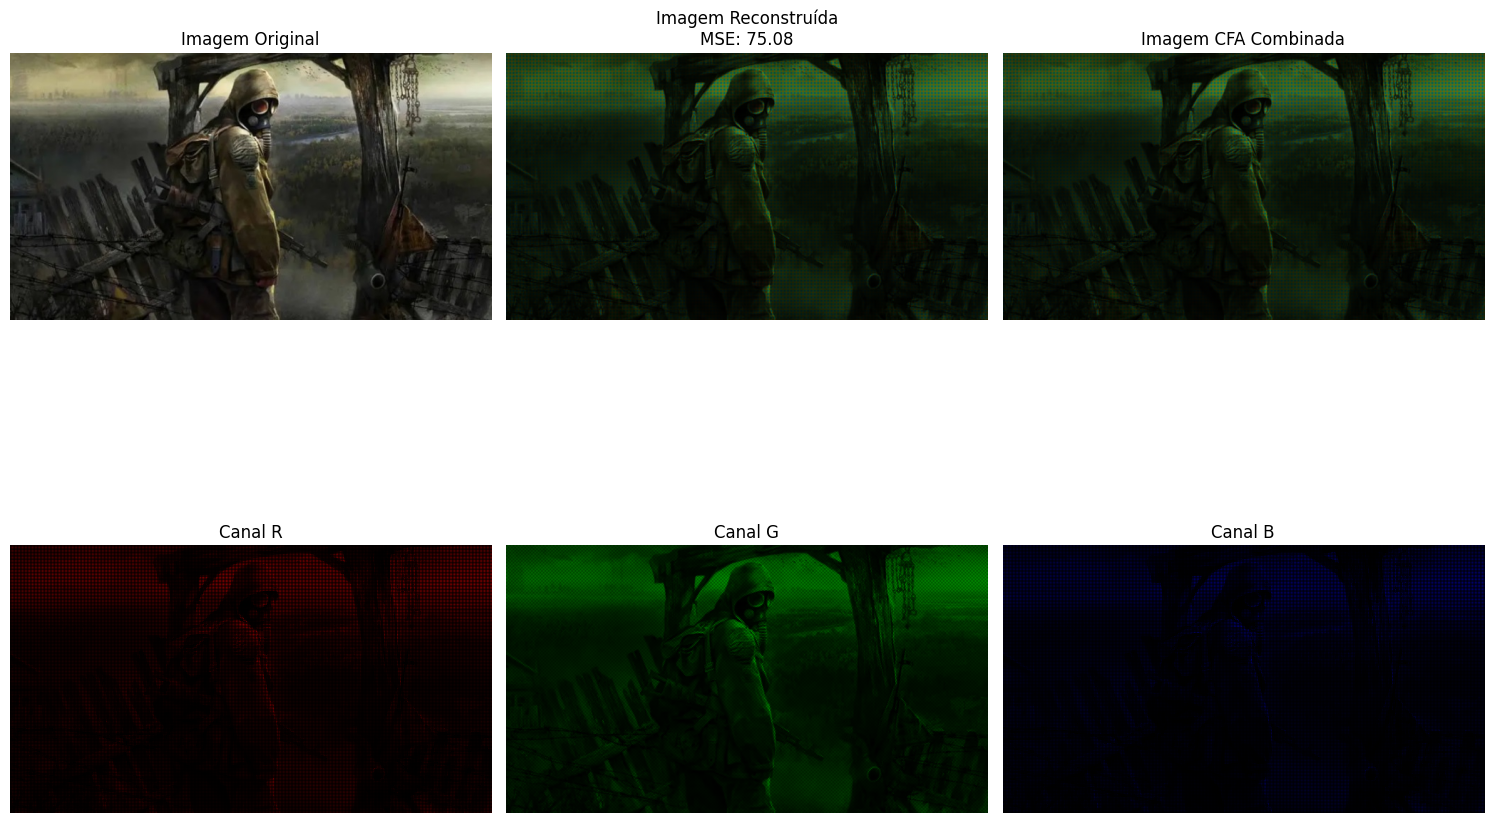

In [ ]:
# Função para simular um filtro CFA (padrão Bayer)
def apply_cfa(image):
    mask_red = np.zeros_like(image, dtype=np.uint8)
    mask_green = np.zeros_like(image, dtype=np.uint8)
    mask_blue = np.zeros_like(image, dtype=np.uint8)

    # Aplicar padrão BGGR
    mask_red[1::2, 1::2, 2] = 1  # Red em posições ímpares
    mask_green[::2, 1::2, 1] = 1  # Green nas linhas pares, colunas ímpares
    mask_green[1::2, ::2, 1] = 1  # Green nas linhas ímpares, colunas pares
    mask_blue[::2, ::2, 0] = 1  # Blue em posições pares

    # Aplicar máscaras na imagem
    red_layer = image * mask_red
    green_layer = image * mask_green
    blue_layer = image * mask_blue

    return red_layer, green_layer, blue_layer

# Função para reconstruir a imagem com interpolação bilinear
def interpolate_cfa_bilinear(red, green, blue):
    # Inicializar a imagem reconstruída
    reconstructed = np.zeros_like(red)

    # Usar OpenCV para aplicar interpolação bilinear em cada canal
    reconstructed[:, :, 2] = cv2.resize(red[:, :, 2], (red.shape[1], red.shape[0]), interpolation=cv2.INTER_LINEAR)
    reconstructed[:, :, 1] = cv2.resize(green[:, :, 1], (green.shape[1], green.shape[0]), interpolation=cv2.INTER_LINEAR)
    reconstructed[:, :, 0] = cv2.resize(blue[:, :, 0], (blue.shape[1], blue.shape[0]), interpolation=cv2.INTER_LINEAR)

    return reconstructed

# Aplicar o CFA para extrair as camadas
red, green, blue = apply_cfa(image)

# Reconstruir a imagem a partir das camadas CFA
reconstructed_image = interpolate_cfa_bilinear(red, green, blue)

mse_value = calculate_mse(image, reconstructed_image)

# Mostrar as imagens
plt.figure(figsize=(20, 10))

# Imagem original
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Imagem Original")
plt.axis("off")

# Imagem Reconstruída
plt.subplot(2, 4, 2)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.title(f"Imagem Reconstruída\nMSE: {mse_value:.2f}")
plt.axis("off")

# Imagem CFA combinada (com valores normalizados)
plt.subplot(2, 4, 3)
cfa_combined = np.clip(red + green + blue, 0, 255)  # Normalizar para evitar valores acima de 255
plt.imshow(cv2.cvtColor(cfa_combined, cv2.COLOR_BGR2RGB))
plt.title("Imagem CFA Combinada")
plt.axis("off")

# Camada Vermelha (Red)
plt.subplot(2, 4, 5)
plt.imshow(cv2.cvtColor(red, cv2.COLOR_RGB2BGR))
plt.title("Canal R")
plt.axis("off")

# Camada Verde (Green)
plt.subplot(2, 4, 6)
plt.imshow(cv2.cvtColor(green, cv2.COLOR_RGB2BGR))
plt.title("Canal G")
plt.axis("off")

# Camada Azul (Blue)
plt.subplot(2, 4, 7)
plt.imshow(cv2.cvtColor(blue, cv2.COLOR_RGB2BGR))
plt.title("Canal B")
plt.axis("off")

plt.tight_layout()
plt.show()


CFA usando o padrao BGGR monocromatico

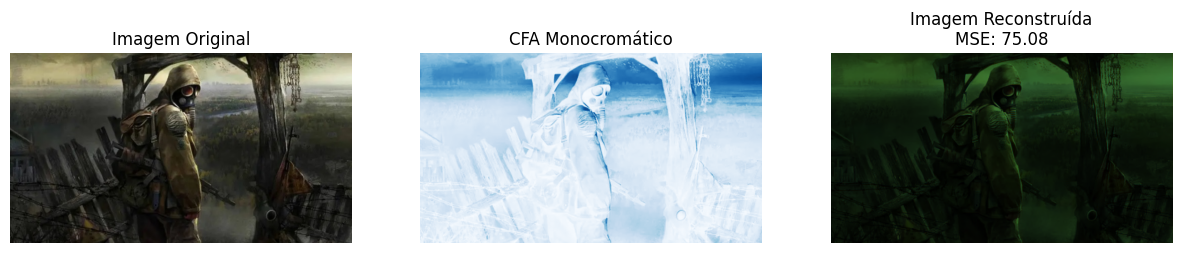

In [ ]:
# Criar matriz monocromática para o CFA
cfa_mono = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Padrão Bayer: BGGR
cfa_mono[::2, ::2] = image[::2, ::2, 0]        # Azul (linhas pares, colunas pares)
cfa_mono[::2, 1::2] = image[::2, 1::2, 1]      # Verde (linhas pares, colunas ímpares)
cfa_mono[1::2, ::2] = image[1::2, ::2, 1]      # Verde (linhas ímpares, colunas pares)
cfa_mono[1::2, 1::2] = image[1::2, 1::2, 2]    # Vermelho (linhas ímpares, colunas ímpares)

# Reconstrução da imagem com interpolação bilinear
def reconstruct_image_from_cfa_bilinear(cfa, pattern="BGGR"):
    # Inicializar tensores para R, G, B
    reconstructed = np.zeros((cfa.shape[0], cfa.shape[1], 3), dtype=np.uint8)

    # Padrão Bayer: BGGR
    if pattern == "BGGR":
        # Preencher diretamente com os valores conhecidos
        reconstructed[::2, ::2, 0] = cfa[::2, ::2]  # Azul
        reconstructed[::2, 1::2, 1] = cfa[::2, 1::2]  # Verde
        reconstructed[1::2, ::2, 1] = cfa[1::2, ::2]  # Verde
        reconstructed[1::2, 1::2, 2] = cfa[1::2, 1::2]  # Vermelho


        # Usar OpenCV para aplicar interpolacao bilinear para cada canal
        for channel in range(3):
            reconstructed[:, :, channel] = cv2.resize(reconstructed[:, :, channel],
                                                     (cfa.shape[1], cfa.shape[0]),
                                                     interpolation=cv2.INTER_LINEAR)

    return reconstructed

# Reconstruir a imagem
reconstructed_image = reconstruct_image_from_cfa_bilinear(cfa_mono)

# Calcular o MSE entre a imagem original e a reconstruída
mse_value = calculate_mse(image, reconstructed_image)

# Mostrar as imagens
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Imagem Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cfa_mono, cmap='Blues')
plt.title("CFA Monocromático")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.title(f"Imagem Reconstruída\nMSE: {mse_value:.2f}")
plt.axis("off")

plt.show()

## Tarefa 2 - Transformações de Intensidade

Criando funções para converter a imagem para tons de cinza, outra para calcular o histograma para a intensidade, e outra para ajuste de gamma.

In [ ]:
def rgb_to_grayscale(image):
    """
    Converte uma imagem RGB para tons de cinza usando a média aritmética dos canais R, G e B.
    :param image: Imagem no formato RGB (array NumPy).
    :return: Imagem em tons de cinza.
    """
    # Calcular a média aritmética dos canais R, G e B
    grayscale = np.mean(image, axis=2)

    # Arredondar os valores para inteiros e converter para tipo uint8
    grayscale = np.round(grayscale).astype(np.uint8)

    return grayscale

def calcular_histograma_cinza(imagem_cinza):
    """
    Calcula e exibe o histograma de uma imagem em tons de cinza.

    :param imagem_cinza: Imagem no formato de tons de cinza.
    """
    # Calcular o histograma
    histograma = cv2.calcHist([imagem_cinza], [0], None, [256], [0, 256])

    # Normalizar o histograma para visualização
    #histograma = histograma / histograma.sum()

    # Exibir o histograma
    plt.figure(figsize=(15, 5))
    plt.bar(range(256), histograma[:, 0], color='gray', width=1.0, edgecolor='black')
    plt.title("Histograma da Imagem em Tons de Cinza")
    plt.xlabel("Intensidade")
    plt.ylabel("Frequência")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def ajustar_gamma(imagem, gamma, k=None):
    """
    Aplica a transformação de intensidade g(x, y) = k * [f(x, y)]^γ.

    :param imagem: Imagem de entrada em tons de cinza.
    :param gamma: Valor do parâmetro γ.
    :param k: Valor de ajuste (se None, será calculado automaticamente para manter [0, 255]).
    :return: Imagem transformada.
    """
    imagem_normalizada = imagem / 255.0  # Normalizar os valores para o intervalo [0, 1]

    if k is None:
        k = 255.0 / (1.0 ** gamma)  # Ajuste para manter o intervalo [0, 255]

    imagem_transformada = k * (imagem_normalizada ** gamma)
    return np.clip(imagem_transformada, 0, 255).astype(np.uint8)

def calcular_histograma(imagem,titulo):
    """
    Calcula e exibe o histograma de uma imagem.
    """
    histograma = cv2.calcHist([imagem], [0], None, [256], [0, 256])
    plt.bar(range(256), histograma[:, 0], color='gray', width=1.0, edgecolor='black')
    plt.title(titulo)
    plt.xlabel("Intensidade")
    plt.ylabel("Frequência")
    plt.grid(axis='y', linestyle='--', alpha=0.7)


Aplicando a conversão de RGB para tons de cinza.

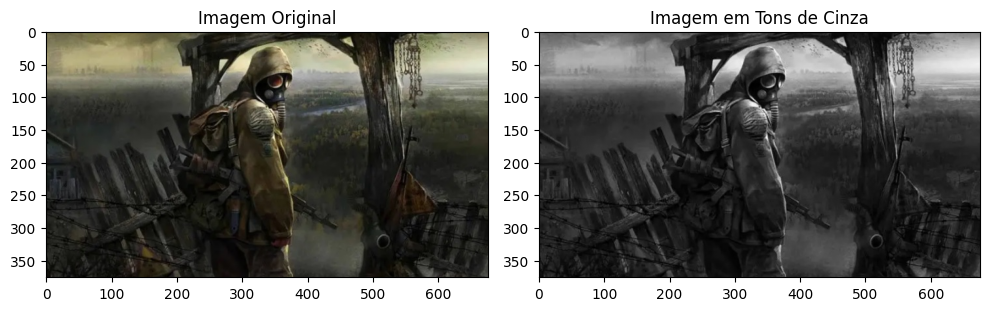

In [ ]:
# Carregar a imagem no formato RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Converter para tons de cinza
grayscale_image = rgb_to_grayscale(image)

# Exibir as imagens
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagem Original")

plt.subplot(1, 2, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.title("Imagem em Tons de Cinza")

plt.tight_layout()
plt.show()

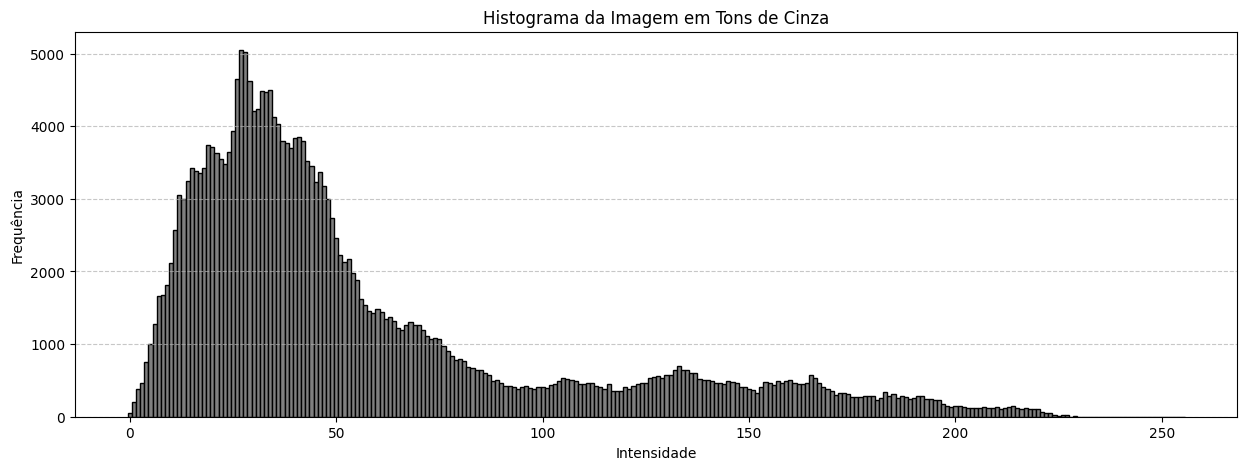

In [ ]:
# Calcular e exibir o histograma
calcular_histograma_cinza(grayscale_image)

Ajuste do gamma na imagem (γ = 0.43, 1.6) e plotando os histogramas para visualizar os valores de bits na imagem de acordor com os ajustes de gamma.

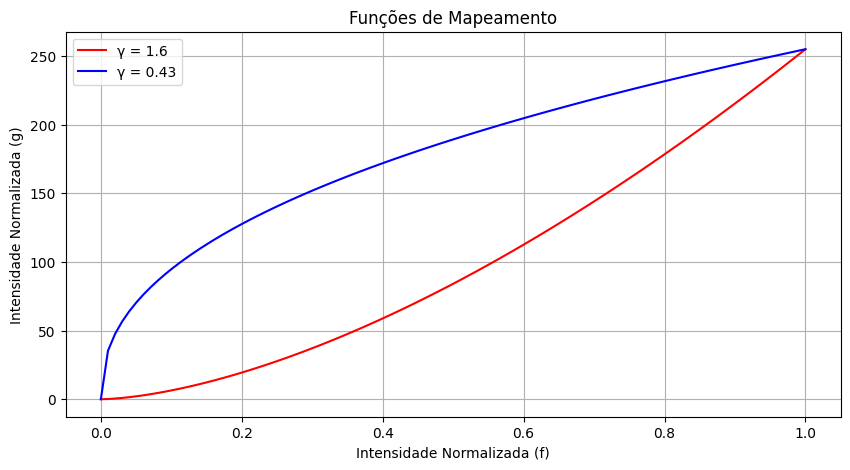

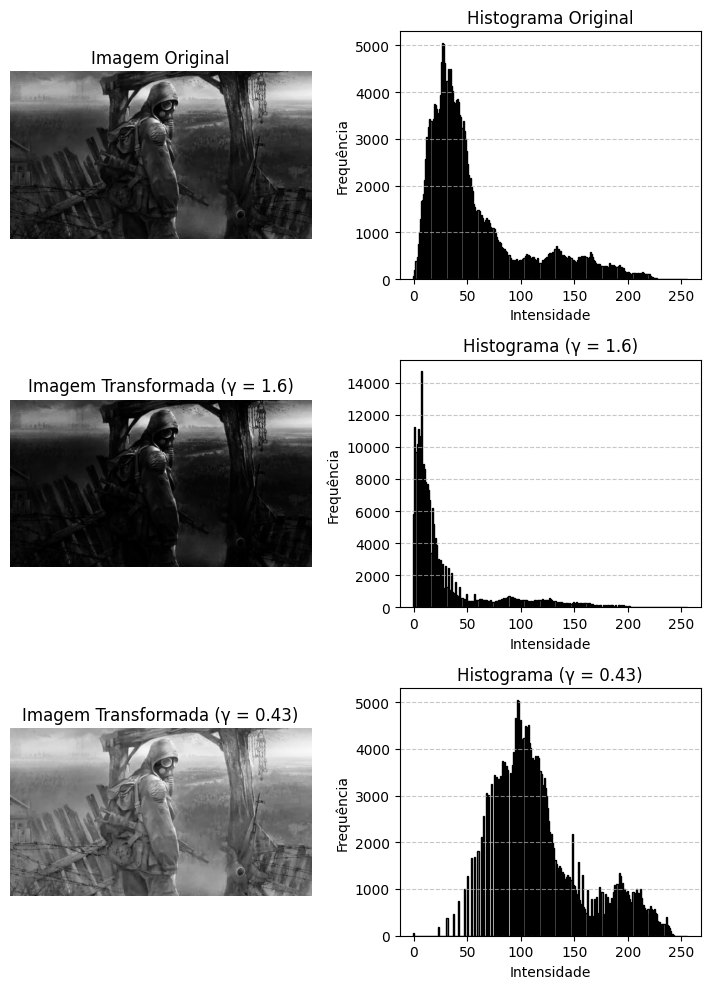

In [ ]:
# Valores de γ para teste
gamma_maior = 1.6  # γ > 1
gamma_menor = 0.43  # γ < 1

# Aplicar transformação de intensidade
imagem_gamma_maior = ajustar_gamma(grayscale_image, gamma_maior)
imagem_gamma_menor = ajustar_gamma(grayscale_image, gamma_menor)

# Gráfico das funções de mapeamento
x = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 5))
plt.plot(x, 255 * (x ** gamma_maior), label=f'γ = {gamma_maior}', color='red')
plt.plot(x, 255 * (x ** gamma_menor), label=f'γ = {gamma_menor}', color='blue')
plt.title("Funções de Mapeamento")
plt.xlabel("Intensidade Normalizada (f)")
plt.ylabel("Intensidade Normalizada (g)")
plt.legend()
plt.grid()
plt.show()

# Mostrar as imagens e histogramas
plt.figure(figsize=(15, 10))

# Imagem original
plt.subplot(3, 4, 1)
plt.imshow(grayscale_image, cmap='gray')
plt.title("Imagem Original")
plt.axis("off")

plt.subplot(3, 4, 2)
calcular_histograma(grayscale_image, "Histograma Original")

# γ > 1
plt.subplot(3, 4, 5)
plt.imshow(imagem_gamma_maior, cmap='gray')
plt.title(f"Imagem Transformada (γ = {gamma_maior})")
plt.axis("off")

plt.subplot(3, 4, 6)
calcular_histograma(imagem_gamma_maior, f"Histograma (γ = {gamma_maior})")

# γ < 1
plt.subplot(3, 4, 9)
plt.imshow(imagem_gamma_menor, cmap='gray')
plt.title(f"Imagem Transformada (γ = {gamma_menor})")
plt.axis("off")

plt.subplot(3, 4, 10)
calcular_histograma(imagem_gamma_menor, f"Histograma (γ = {gamma_menor})")

plt.tight_layout()
plt.show()

Equalizando a imagem a partir de uma variavel aleatoria.

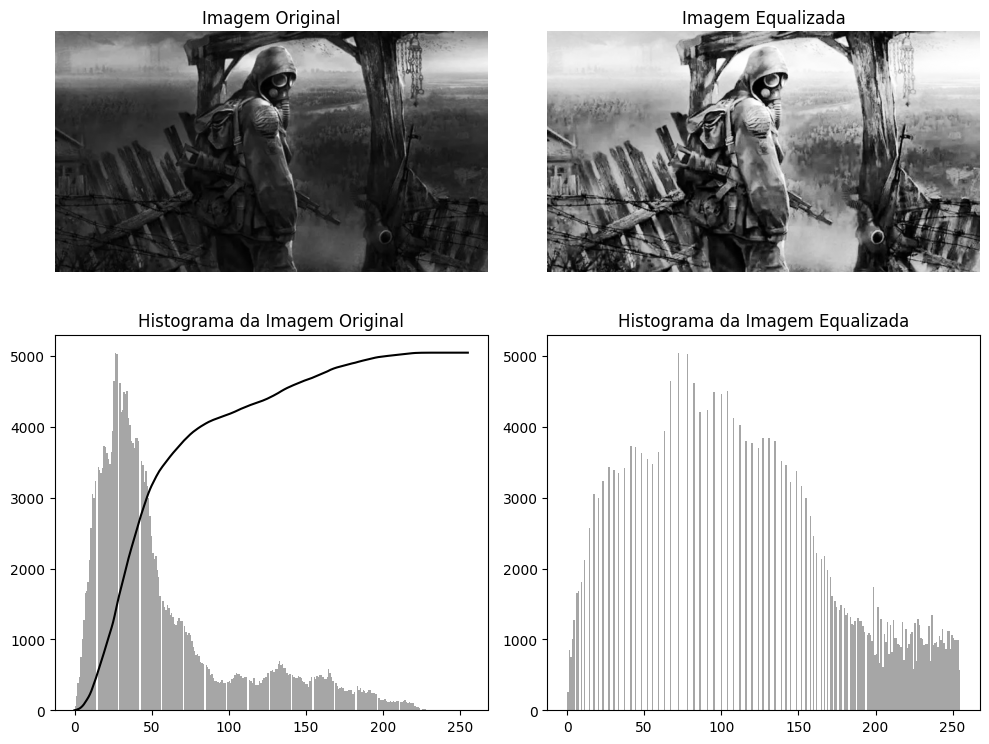

In [ ]:
hist_original, bins = np.histogram(grayscale_image.flatten(), 256, [0, 256])

# Calcular a CDF (função de distribuição acumulada)
cdf = hist_original.cumsum()
cdf_normalizada = cdf * hist_original.max() / cdf.max()

# Equalizar o histograma: mapeando os valores de intensidade
imagem_equalizada = cv2.equalizeHist(grayscale_image)

# Calcular o histograma da imagem equalizada
hist_equalizado, _ = np.histogram(imagem_equalizada.flatten(), 256, [0, 256])

# Plotar a imagem original, a imagem equalizada e seus histogramas
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Imagem original
axes[0, 0].imshow(grayscale_image, cmap='gray')
axes[0, 0].set_title('Imagem Original')
axes[0, 0].axis('off')

# Imagem equalizada
axes[0, 1].imshow(imagem_equalizada, cmap='gray')
axes[0, 1].set_title('Imagem Equalizada')
axes[0, 1].axis('off')

# Histograma da imagem original
axes[1, 0].plot(cdf_normalizada, color='black')
axes[1, 0].hist(grayscale_image.flatten(), bins=256, color='gray', alpha=0.7)
axes[1, 0].set_title('Histograma da Imagem Original')

# Histograma da imagem equalizada
axes[1, 1].hist(imagem_equalizada.flatten(), bins=256, color='gray', alpha=0.7)
axes[1, 1].set_title('Histograma da Imagem Equalizada')

plt.tight_layout()
plt.show()

## Tarefa 3 - Filtragem


Criar funções para criar o filtro uniforme e o filtro gaussiano, também para plotar em 3D.

In [ ]:
def uniform_filter(L):
    """Creates a 2D uniform filter of size LxL."""
    return np.ones((L, L)) / (L**2)

def gaussian_filter(sigma):
    """Creates a 2D Gaussian filter with standard deviation sigma."""
    size = int(np.ceil(10 * sigma))  # Ensure the filter covers -5sigma to +5sigma
    if size % 2 == 0:
        size += 1  # Make sure the size is odd
    ax = np.arange(-(size // 2), (size // 2) + 1)
    x, y = np.meshgrid(ax, ax)
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))
    #return gaussian / np.sum(gaussian)

def plot_3d_surface(data, title, xlabel, ylabel, zlabel):
    """Plots a 3D surface."""
    rows, cols = data.shape
    x = np.linspace(-cols / 2, cols / 2, cols)
    y = np.linspace(-rows / 2, rows / 2, rows)
    X, Y = np.meshgrid(x, y)
    #X, Y = np.meshgrid(range(data.shape[1]), range(data.shape[0]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, data, edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()

def apply_filter(image, filter, L):
    """Applies a uniform filter to an image and plots the result."""
    filtered_image = convolve2d(image, filter, mode='same', boundary='symm')
    plt.figure()
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f"Imagem Filtrada ({L})")
    plt.show()
    return filtered_image

Aplicação do filtro uniforme com L (3 e 15) com o plote da resposta ao impulo e frequência em 3D.

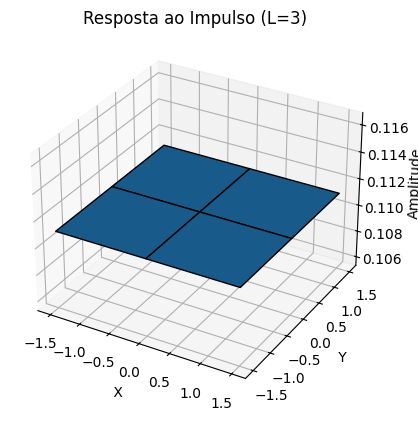

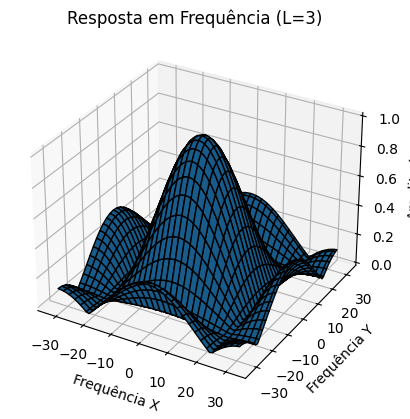

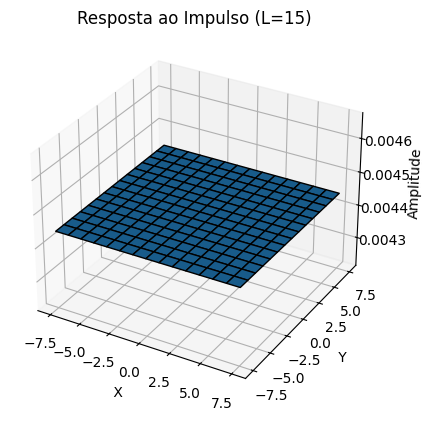

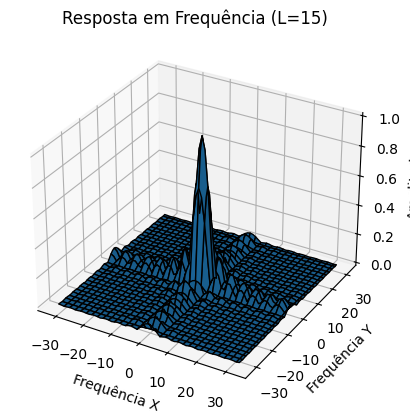

In [ ]:
# Define filter sizes
filter_sizes = [3, 15]

imagem = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#imagem = np.float64(imagem)

for L in filter_sizes:
    # Create the uniform filter
    filter = uniform_filter(L)

    # Plot the impulse response
    plot_3d_surface(filter, f"Resposta ao Impulso (L={L})", " X", " Y", "Amplitude")

    # Compute the frequency response
    freq_response = np.fft.fftshift(np.abs(np.fft.fft2(filter, s=(64, 64))))

    # Plot the magnitude of the frequency response
    plot_3d_surface(freq_response, f"Resposta em Frequência (L={L})", "Frequência X", "Frequência Y", "Amplitude")


Plote das imagens filtradas.

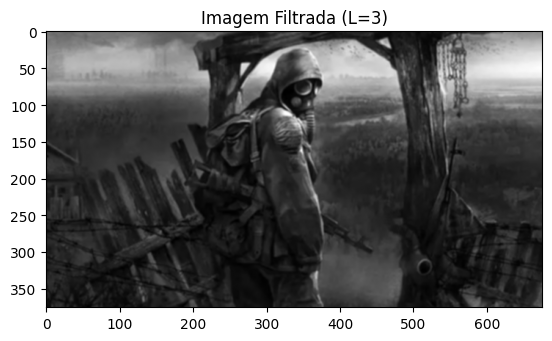

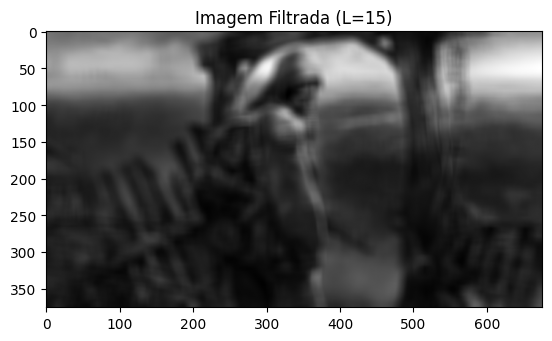

In [ ]:
filter_image = [apply_filter(grayscale_image, uniform_filter(L), f"L={L}") for L in filter_sizes]

Aplicação do filtro gaussiano com sigma (3 e 9). E plote das respostas do filtro em 3D e das imagens filtradas.

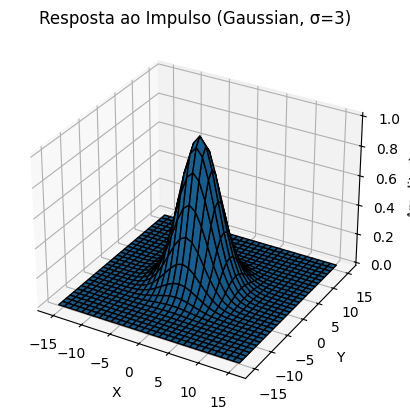

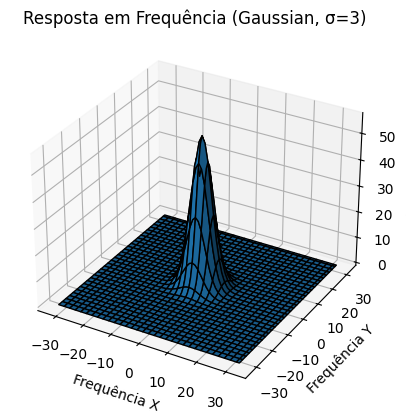

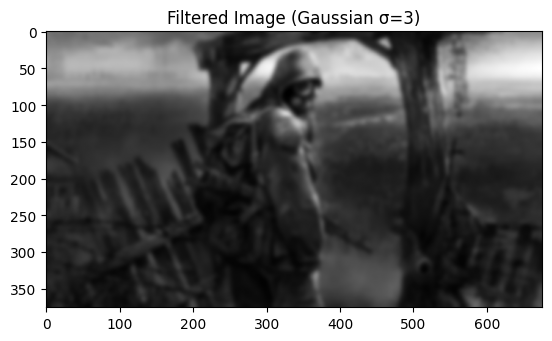

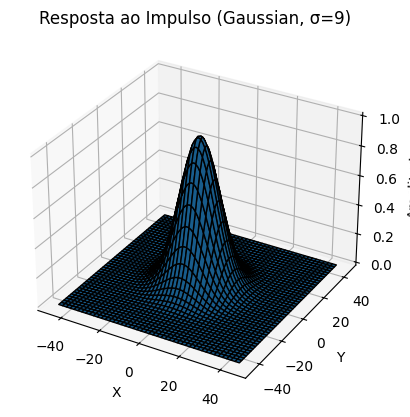

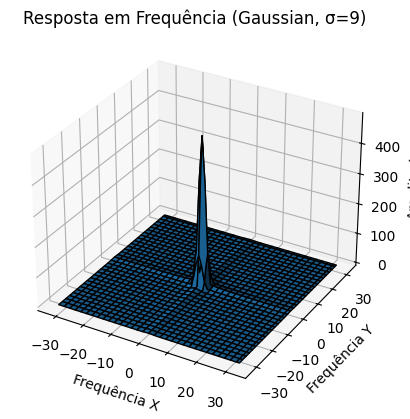

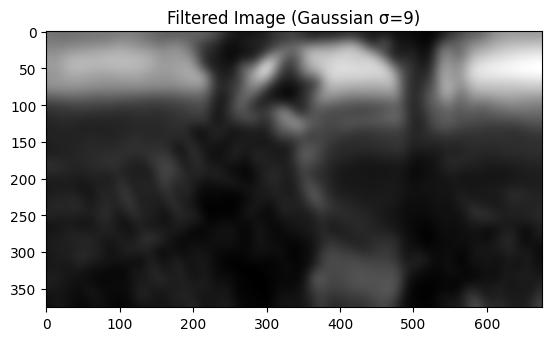

In [ ]:
sigmas = [3, 9]

for sigma in sigmas:
    # Create the Gaussian filter
    filter = gaussian_filter(sigma)

    # Plot the impulse response
    plot_3d_surface(filter, f"Resposta ao Impulso (Gaussian, σ={sigma})", "X", "Y", "Amplitude")

    # Compute the frequency response
    freq_response = np.fft.fftshift(np.abs(np.fft.fft2(filter, s=(64, 64))))

    # Plot the magnitude of the frequency response
    plot_3d_surface(freq_response, f"Resposta em Frequência (Gaussian, σ={sigma})", "Frequência X", "Frequência Y", "Amplitude")

    # Apply the filter to the image and display the result
    filtered_image = apply_filter(imagem, filter, f"Gaussian σ={sigma}")

Criando uma função para aplicar o ruido branco de 5dB a imagem e aplicar os filtros gaussiano, mediano e estatistico para tentar melhorar a imagem a partir do calculo do MSE para avaliar.

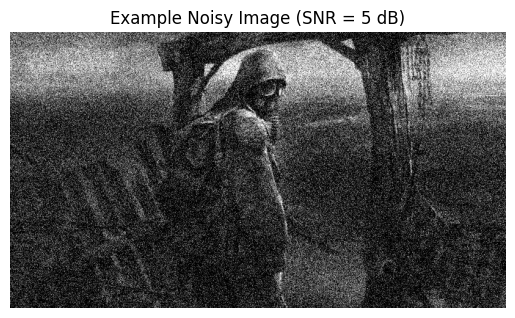

Optimal sigma for Filtro Gaussiano: 0.5, MSE: 3979.2590774910727


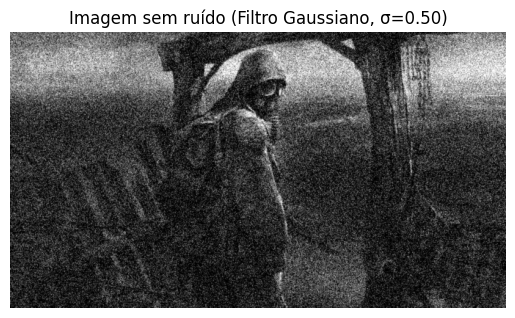

Optimal kernel size for Median filter: 11, MSE: 53.39299402776029


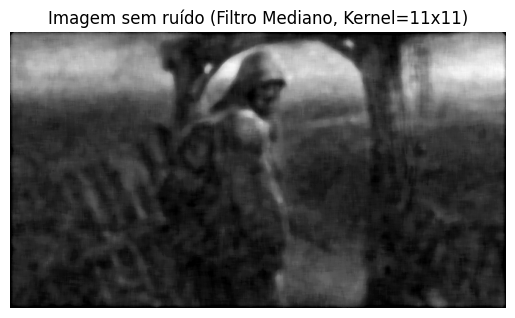

MSE (Filtro Estatı́stico): 103.24610637904443


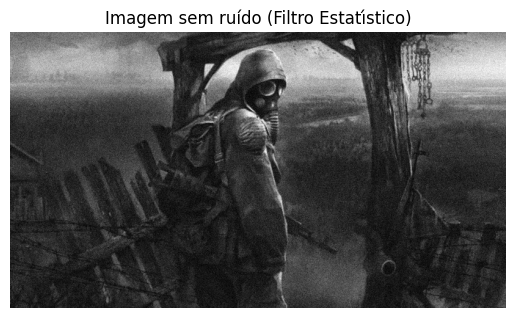

Valores de MSE:
Filtragem Gaussiana: MSE = 3979.2590774910727
Filtragem Mediana: MSE = 53.39299402776029
Filtragem Estatı́stica: MSE = 103.24610637904443


In [ ]:
def add_awgn(image, snr_db):
    """Adds Additive White Gaussian Noise (AWGN) to an image at a specified SNR."""

    image = image.astype(np.float32)
    mean_signal = np.mean(image**2)
    sigma_noise = np.sqrt(mean_signal / (10**(snr_db / 10)))
    noise = np.random.normal(0, sigma_noise, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Generate 20 noisy images with SNR = 5 dB
num_images = 20
snr_db = 5
noisy_images = [add_awgn(imagem, snr_db) for _ in range(num_images)]

# Display one of the noisy images
plt.figure()
plt.imshow(noisy_images[0], cmap='gray')
plt.title("Example Noisy Image (SNR = 5 dB)")
plt.axis('off')
plt.show()

# Part a: Denoising using Gaussian filter
optimal_sigma = None
min_mse_gaussian = float('inf')
processed_gaussian = None

for sigma in np.linspace(0.5, 5, 10):  # Test different sigma values
    filt = gaussian_filter(sigma)
    denoised_images = [convolve2d(img, filt, mode='same', boundary='symm') for img in noisy_images]
    #avg_denoised = np.mean(denoised_images, axis=0)
    mse = [calculate_mse(imagem, denoised) for denoised in denoised_images]
    avg_mse = np.mean(mse)
    if avg_mse < min_mse_gaussian:
        min_mse_gaussian = avg_mse
        optimal_sigma = sigma
        processed_gaussian = denoised_images


print(f"Optimal sigma for Filtro Gaussiano: {optimal_sigma}, MSE: {min_mse_gaussian}")

plt.figure()
plt.imshow(processed_gaussian[0], cmap='gray')
plt.title(f"Imagem sem ruído (Filtro Gaussiano, σ={optimal_sigma:.2f})")
plt.axis('off')
plt.show()

# Part b: Denoising using Median filter
optimal_kernel_size = None
min_mse_median = float('inf')
processed_median = None

for kernel_size in range(3, 12, 2):  # Test odd kernel sizes from 3x3 to 11x11
    denoised_images = [medfilt2d(img, kernel_size=kernel_size) for img in noisy_images]
    #avg_denoised = np.mean(denoised_images, axis=0)
    mse = [calculate_mse(imagem, denoised) for denoised in denoised_images]
    avg_mse = np.mean(mse)
    if avg_mse < min_mse_median:
        min_mse_median = avg_mse
        optimal_kernel_size = kernel_size
        processed_median = denoised_images

print(f"Optimal kernel size for Median filter: {optimal_kernel_size}, MSE: {min_mse_median}")

plt.figure()
plt.imshow(processed_median[0], cmap='gray')
plt.title(f"Imagem sem ruído (Filtro Mediano, Kernel={optimal_kernel_size}x{optimal_kernel_size})")
plt.axis('off')
plt.show()

# Part c: Denoising using statistical averaging
processed_statistical = np.mean(noisy_images, axis=0)
mse_statistical = calculate_mse(imagem, processed_statistical)

print(f"MSE (Filtro Estatı́stico): {mse_statistical}")

plt.figure()
plt.imshow(processed_statistical, cmap='gray')
plt.title("Imagem sem ruído (Filtro Estatı́stico)")
plt.axis('off')
plt.show()

# Summary
print("Valores de MSE:")
print(f"Filtragem Gaussiana: MSE = {min_mse_gaussian}")
print(f"Filtragem Mediana: MSE = {min_mse_median}")
print(f"Filtragem Estatı́stica: MSE = {mse_statistical}")

Criando uma função para aplicar ruido sal e pimenta a 50% dos pixels e usando os filtros uniforme e mediano na imagem.

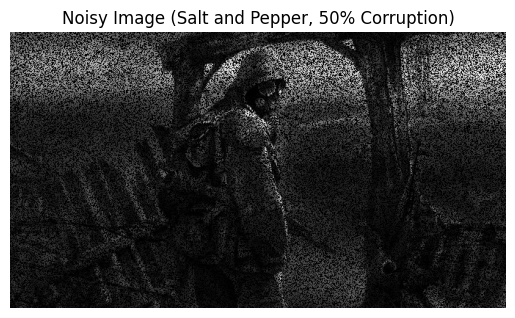

Optimal size for Uniform filter: 3, MSE: 1250.3077236848042


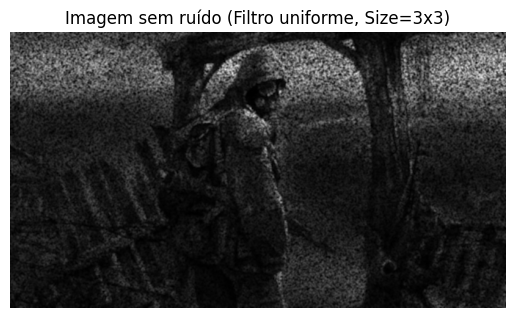

Optimal kernel size for Median filter: 5, MSE: 59.4853566032985


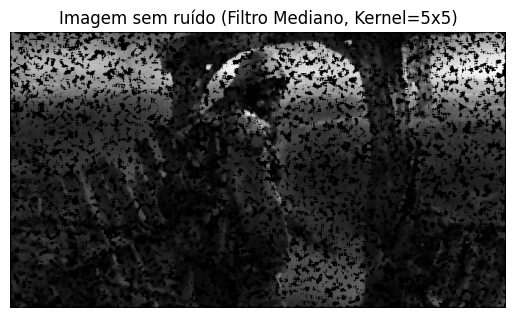

Valores de MSE:
Filtragem Uniforme: MSE = 1250.3077236848042
Filtragem Mediana: MSE = 59.4853566032985


In [ ]:
def add_salt_and_pepper(image, corruption_percent):
    """Adds salt-and-pepper noise to an image."""
    noisy_image = np.copy(image)
    total_pixels = image.size
    num_corrupted = int(total_pixels * corruption_percent / 100)

    # Salt noise
    salt_indices = np.random.choice(total_pixels, num_corrupted // 2, replace=False)
    noisy_image.ravel()[salt_indices] = np.random.uniform(230, 255, len(salt_indices)) / 255

    # Pepper noise
    pepper_indices = np.random.choice(total_pixels, num_corrupted // 2, replace=False)
    noisy_image.ravel()[pepper_indices] = np.random.uniform(0, 25, len(pepper_indices)) / 255

    return noisy_image

corruption_percent = 50
noisy_image_sp = add_salt_and_pepper(imagem, corruption_percent)

# Display the noisy image
plt.figure()
plt.imshow(noisy_image_sp, cmap='gray')
plt.title(f"Noisy Image (Salt and Pepper, {corruption_percent}% Corruption)")
plt.axis('off')
plt.show()

L = 3
filter = uniform_filter(L)
denoised_image = convolve2d(noisy_image_sp, filter, mode='same', boundary='symm')
uniforme_mse = calculate_mse(imagem, denoised_image)

print(f"Optimal size for Uniform filter: {L}, MSE: {uniforme_mse}")

plt.figure()
plt.imshow(denoised_image, cmap='gray')
plt.title(f"Imagem sem ruído (Filtro uniforme, Size={L}x{L})")
plt.axis('off')
plt.show()

kernel = 5
denoised_image = medfilt2d(noisy_image_sp, kernel_size=kernel)
median_mse = calculate_mse(imagem, denoised_image)

print(f"Optimal kernel size for Median filter: {kernel}, MSE: {median_mse}")

plt.figure()
plt.imshow(denoised_image, cmap='gray')
plt.title(f"Imagem sem ruído (Filtro Mediano, Kernel={kernel}x{kernel})")
plt.axis('off')
plt.show()

# Summary
print("Valores de MSE:")
print(f"Filtragem Uniforme: MSE = {uniforme_mse}")
print(f"Filtragem Mediana: MSE = {median_mse}")


Fazendo a filtragem da imagem no dominio da frequencia, a partir de uma nova função do filtro gaussiano dimensionando-o para as dimensões da imagem. Assim tendo resultados parecidos com a filtragem usando a convolução.

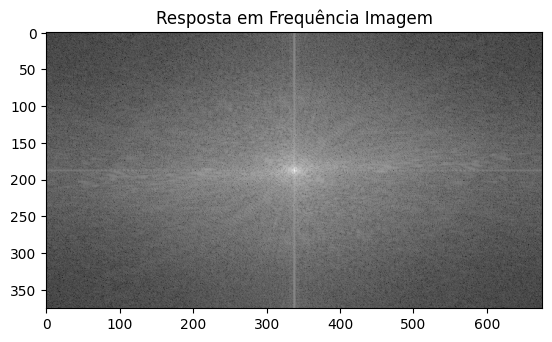

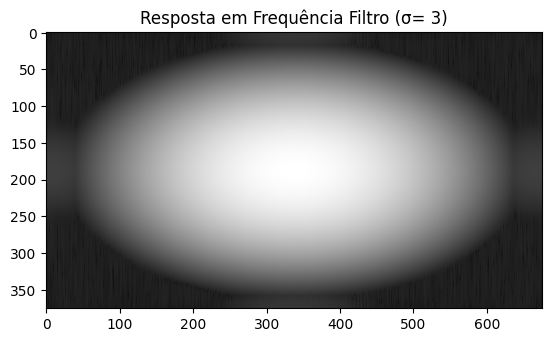

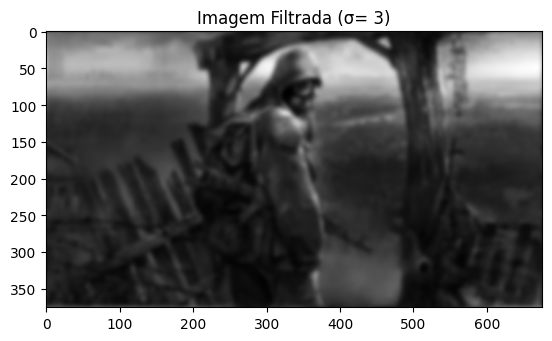

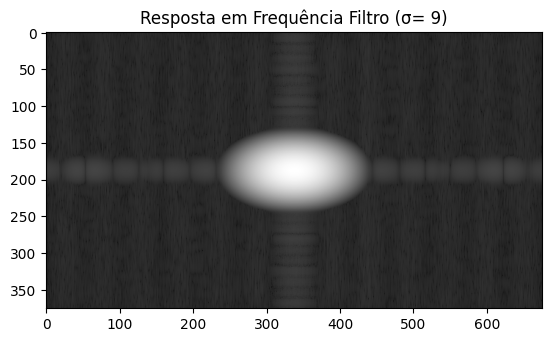

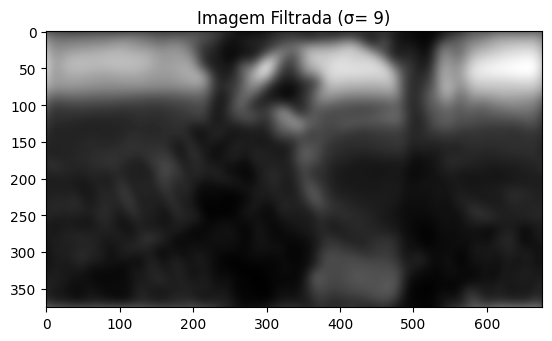

In [ ]:
def gaussian_filter_spatial(sigma, image):
    """
    Cria um kernel Gaussiano com coordenadas ajustadas ao tamanho da imagem.

    :param sigma: Desvio padrão do filtro.
    :param image_shape: Tupla (altura, largura) da imagem.
    :return: Kernel Gaussiano normalizado.
    """
    H, W = image.shape[:2]  # Altura e largura da imagem
    x = np.linspace(-W//2, W//2, W)  # Coordenadas x centradas
    y = np.linspace(-H//2, H//2, H)  # Coordenadas y centradas
    X, Y = np.meshgrid(x, y)
    gaussian = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return np.fft.ifftshift(gaussian)

image_fft = np.fft.fft2(imagem)
image_fft = np.fft.fftshift(image_fft)
plt.imshow(np.log(np.abs(image_fft)), cmap='gray')
plt.title('Resposta em Frequência Imagem')
plt.show()

for sigma in sigmas:

  filter = gaussian_filter_spatial(sigma, imagem)
  filter_fft = np.fft.fft2(filter)
  filter_fft = np.fft.fftshift(filter_fft)
  plt.imshow(np.log(20*np.abs(filter_fft)), cmap='gray')
  plt.title(f'Resposta em Frequência Filtro (σ= {sigma})')
  plt.show()

  filt_image = filter_fft * image_fft
  filt_image = np.fft.ifftshift(filt_image)
  filt_image = np.fft.ifft2(filt_image)
  abs = np.abs(filt_image)
  filt_image = np.uint8(255*abs/np.max(abs))

  plt.imshow(filt_image, cmap='gray')
  plt.title(f'Imagem Filtrada (σ= {sigma})')
  plt.show()


Fazendo uma filtragem de teste usando a função de transferencia do filtro gaussiano.

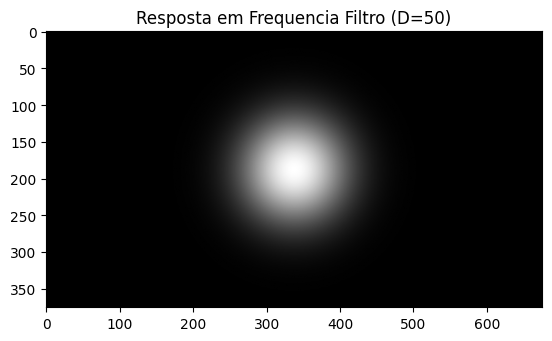

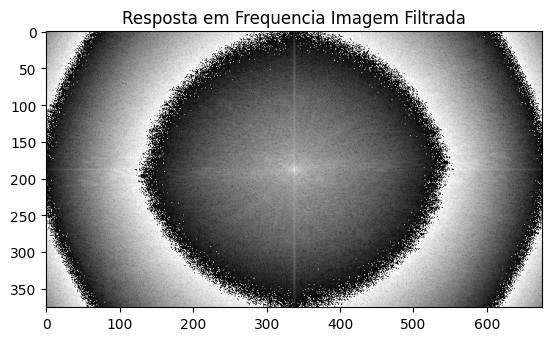

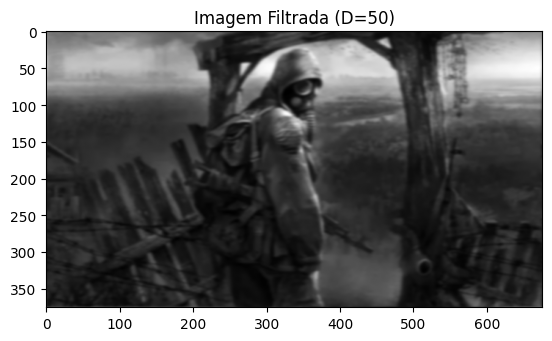

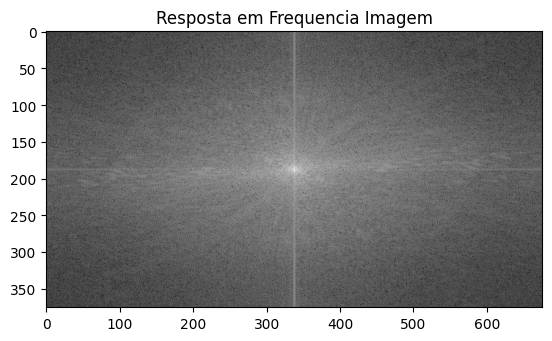

In [ ]:
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

D = 50
plt.imshow(gaussianLP(D, imagem.shape), cmap='gray')
plt.title(f'Resposta em Frequencia Filtro (D={D})')
plt.show()

fft_image = np.fft.fft2(imagem)
fft_image = np.fft.fftshift(fft_image)
abs = np.abs(fft_image)
fft_log = 20*np.log10(abs)
img_frr = np.uint8(255*fft_log/np.max(fft_log))


lowpass = fft_image * gaussianLP(D, imagem.shape)
filt_abs = np.abs(lowpass)
filt_log = 20*np.log10(filt_abs)
gaussian = np.uint8(255*filt_log/np.max(filt_log))
plt.imshow(gaussian, cmap='gray')
plt.title('Resposta em Frequencia Imagem Filtrada')
plt.show()

inverse_filt = np.fft.ifft2(lowpass)
inverse_filt = np.abs(inverse_filt)
plt.imshow(inverse_filt, cmap='gray')
plt.title(f'Imagem Filtrada (D={D})')
plt.show()

plt.imshow(img_frr, cmap='gray')
plt.title('Resposta em Frequencia Imagem')
plt.show()

## Tarefa 4 - JPEG


Convertendo o mapa de cores de RGB para YCbCr, usando um array com os valores onde será multiplicado com os canais RGB, e depois adionar um offset nos canais Cb e Cr para assim converter os mapas de cores.

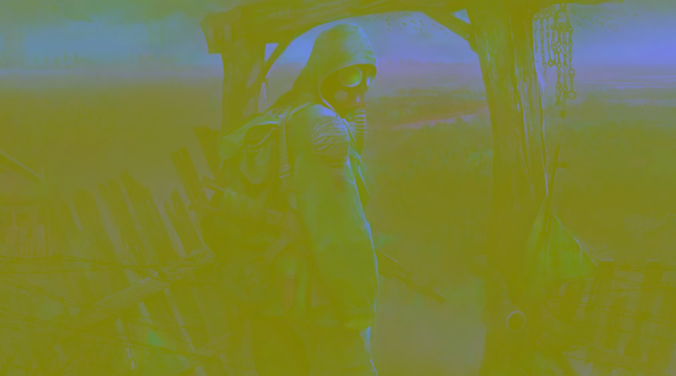

In [ ]:
def rbg_ycbcr(image):
  xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
  ycbcr = image.dot(xform.T)
  ycbcr[:,:,[1,2]] += 128
  return np.uint8(ycbcr)

ycbcr_image = rbg_ycbcr(image)
cv2_imshow (ycbcr_image)

Tres funções criadas, uma para criar padding caso as dimensões da imagem não sejam divisiveis por 8, outra para criar os blocos 8x8 e a ultima para aplicar a dct na nos blocos.

Depois das funções, os canais foram separados e aplicado o subsampling 4:2:2. Depois cria-se os padding na largura da imagem e divide os blocos em 8x8. E por ultimo é calculado a dct em cada bloco com os canais separados.

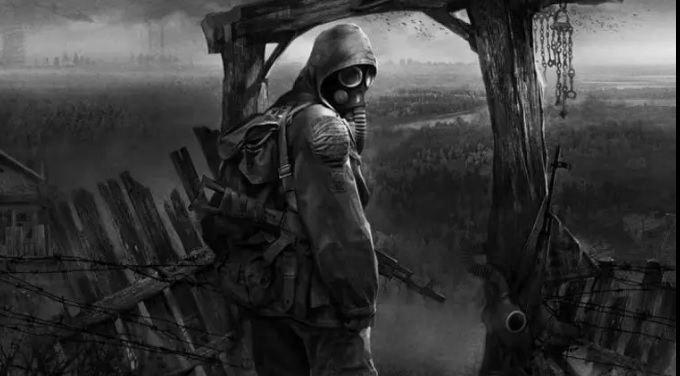

In [ ]:
def padding (comp):
  height, width = comp.shape
  padded_height = (height + 8 - 1) // 8*8
  padded_width = (width + 8 - 1) // 8*8
  padded_image = np.zeros((padded_height, padded_width), dtype=image.dtype)
  padded_image[:height, :width] = comp
  return padded_image

def block_extraction(image):
  blocks = []
  for i in range(0, image.shape[0], 8):
    for j in range(0, image.shape[1], 8):
      block = image[i:i+8, j:j+8]
      blocks.append(block)
  return blocks

def calculate_dct(block):
  return dct(dct(block.T, norm='ortho').T, norm='ortho')

Y = ycbcr_image[:,:,0]
sub_Cb = ycbcr_image[::2,::2,1]
sub_Cr = ycbcr_image[::2,::2,2]

pad_Y = padding(Y)
pad_Cb = padding(sub_Cb)
pad_Cr = padding(sub_Cr)

Y_block = block_extraction(pad_Y)
Cb_block = block_extraction(pad_Cb)
Cr_block = block_extraction(pad_Cr)

dct_Y = [calculate_dct(block) for block in Y_block]
dct_Cb = [calculate_dct(block) for block in Cb_block]
dct_Cr = [calculate_dct(block) for block in Cr_block]

cv2_imshow(pad_Y)

Para a quantização, é usado dois arrays, um para aplicar no canal Y e o outro para os canais Cb e Cr, depois cada block é quantizado aplicando a tabela de quantização para os canais certos.

In [ ]:
QY = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float32)

# Matriz de quantização para crominância (Cb, Cr)
QC = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
], dtype=np.float32)

def quantization(block, Q):
  return np.round(block / Q)

quantized_Y = [quantization(block, QY) for block in dct_Y]
quantized_Cb = [quantization(block, QC) for block in dct_Cb]
quantized_Cr = [quantization(block, QC) for block in dct_Cr]

Para desfazer é aplicado todos os passos inversamente para calcular o MSE, verificando o processo de codificação JPEG.

MSE: 20.257841023542742


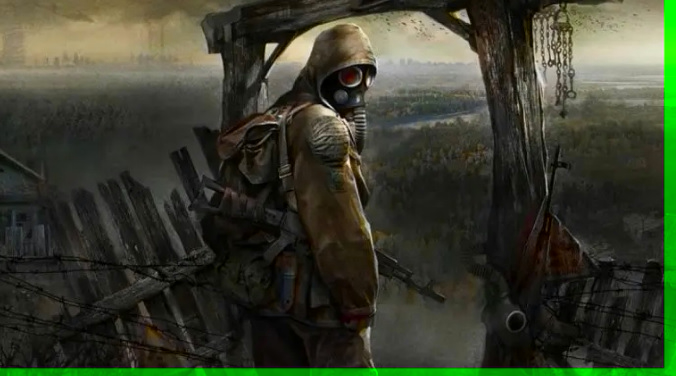

In [ ]:

# Função para aplicar a IDCT e reconstruir os blocos
def apply_idct(quantized_block):
    return idct(idct(quantized_block.T, norm='ortho').T, norm='ortho')

def reconstruct_comp(blocks, Q, comp):
  index = 0
  for i in range(0, comp.shape[0], 8):
    for j in range(0, comp.shape[1], 8):
      block = blocks[index]
      dequantized_block = block * Q
      reconstruct_comp = apply_idct(dequantized_block)
      comp[i:i+8, j:j+8] = reconstruct_comp
      index += 1
      return comp

reconstructed_Y = reconstruct_comp(quantized_Y, QY, pad_Y)
reconstructed_Cb = reconstruct_comp(quantized_Cb, QC, pad_Cb)
reconstructed_Cr = reconstruct_comp(quantized_Cr, QC, pad_Cr)

original_height, original_width = image.shape[:2]  # Pegando altura e largura originais

# Removendo o padding
reconstructed_Y = reconstructed_Y[:original_height, :original_width]
reconstructed_Cb = reconstructed_Cb[:original_height, :original_width]
reconstructed_Cr = reconstructed_Cr[:original_height, :original_width]
# Exibe a imagem reconstruída
if reconstructed_Cb.shape != reconstructed_Y.shape:
    reconstructed_Cb = cv2.resize(reconstructed_Cb, (reconstructed_Y.shape[1], reconstructed_Y.shape[0]), interpolation=cv2.INTER_CUBIC)
    reconstructed_Cr = cv2.resize(reconstructed_Cr, (reconstructed_Y.shape[1], reconstructed_Y.shape[0]), interpolation=cv2.INTER_CUBIC)

# Junta os canais para formar a imagem YCbCr
reconstructed_YCbCr = np.stack([reconstructed_Y, reconstructed_Cb, reconstructed_Cr], axis=2)

# Converte para RGB para exibir corretamente
reconstructed_RGB = cv2.cvtColor(reconstructed_YCbCr.astype(np.uint8), cv2.COLOR_YCrCb2BGR)

mse = calculate_mse(image, reconstructed_RGB)
print(f"MSE: {mse}")
# Mostra a imagem reconstruída
cv2_imshow(reconstructed_RGB)
cv2.waitKey(0)
cv2.destroyAllWindows()